### Progetto esame Analisi e Gestione Dati per la Biomedica

Autore: Gianluca Andretta MAT. 0327000510

4 POSSIBILI PROGETTI

1. SKIN CANCER CLASSIFICATION
2. RESPIRATORY AUDIO ANALYSIS CLASSIFICATION
3. POLLEN FORECASTING FOR ALLERGY MEDICATION PURPOSES


In [201]:
from operator import itemgetter
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler

In [202]:
# POLLEN
# https://data.civis.bz.it/dataset/italian-pollnet-webservices


# PART_SEQ: numero progressivo della particella
# PART_LEVEL: livello di gerarchia
# PART_ID: codice numerico della particella
# PART_NAME_L: nome scientifico (latino) della particella
# PART_PARENT_NAME_L: nome del gruppo a cui è assegnata la particella
# REMA_CONCENTRATION: concentrazione media giornaliera della particella
# REMA_DATE: data
# STAT_ID: codice numerico assegnato alla stazione di monitoraggio
# STAT_CODE: codice alfanumerico della stazione di monitoraggio
# STAT_NAME_I: nome italiano della stazione di monitoraggio
# STAT_NAME_D: nome tedesco della stazione di monitoraggio

# recap annuale
# http://dati.retecivica.bz.it/services/POLLNET_YEAR_REP?format=json&STAT_ID=1&PART_ID=1362&from=2016-01-01

# media giornaliera
# http://dati.retecivica.bz.it/services/POLLNET_YEAR_REP?format=json&STAT_ID=131&PART_ID=1&from=2016-01-01&to=2024-01-01


# ANNUALE - GRAMINCEE 1352 Napoli 131
# https://dati.retecivica.bz.it/services/POLLNET_YEAR_REP?format=json&STAT_ID=131&PART_ID=1352&from=2022-01-01

# GIORNALIERO 2018 -> 2024
# https://dati.retecivica.bz.it/services/POLLNET_REMARKS?format=json&PART_ID=1352&from=2018-01-01&to=2024-01-01&STAT_ID=131

In [203]:
# SEARCH THE PART_ID OF graminacee and alternaria or whetever the patient is more sensible to

res = requests.get(
    "https://dati.retecivica.bz.it/services/POLLNET_PARTICLES?format=json"
)
pollen_types = res.json()
pollen_names = [p.get("PART_NAME_I") for p in pollen_types]
idxes = [
    i
    for i, name in enumerate(pollen_names)
    if sum(list(map(lambda x: x in name.lower(), ["graminacee", "alternaria"])))
]

pollens = list(
    map(itemgetter("PART_ID", "PART_NAME_I"), itemgetter(*idxes)(pollen_types))
)

pollens

[(1352, 'Graminacee'), (1364, 'Alternaria')]

In [204]:
# DAILY 2018 -> 2024 - GRAMINACEE
daily_url = "https://dati.retecivica.bz.it/services/POLLNET_REMARKS?format=json&PART_ID=1352&from=2018-01-01&to=2024-01-01&STAT_ID=131"
res = requests.get(daily_url)
data = res.json()
for point in data:
    point["REMA_DATE"] = datetime.strptime(point["REMA_DATE"], "%Y-%m-%dT%H:%M:%S")


records = []
current_date = data[0].get("REMA_DATE")
missing_days = []
for point in data:
    records.append(
        {"date": current_date, "concentration": point.get("REMA_CONCENTRATION")}
    )

    while current_date != point["REMA_DATE"]:
        missing_days.append(current_date)
        current_date += timedelta(days=1)
        records.append({"date": current_date, "concentration": None})
    current_date += timedelta(days=1)

print(len(missing_days), "missing days concentration")
print(len(records), "data points ")

df = pd.DataFrame(records)
df.iloc[0]
df.to_csv("pollen_data_points_2018_2024.csv", index=False)

150 missing days concentration
2192 data points 


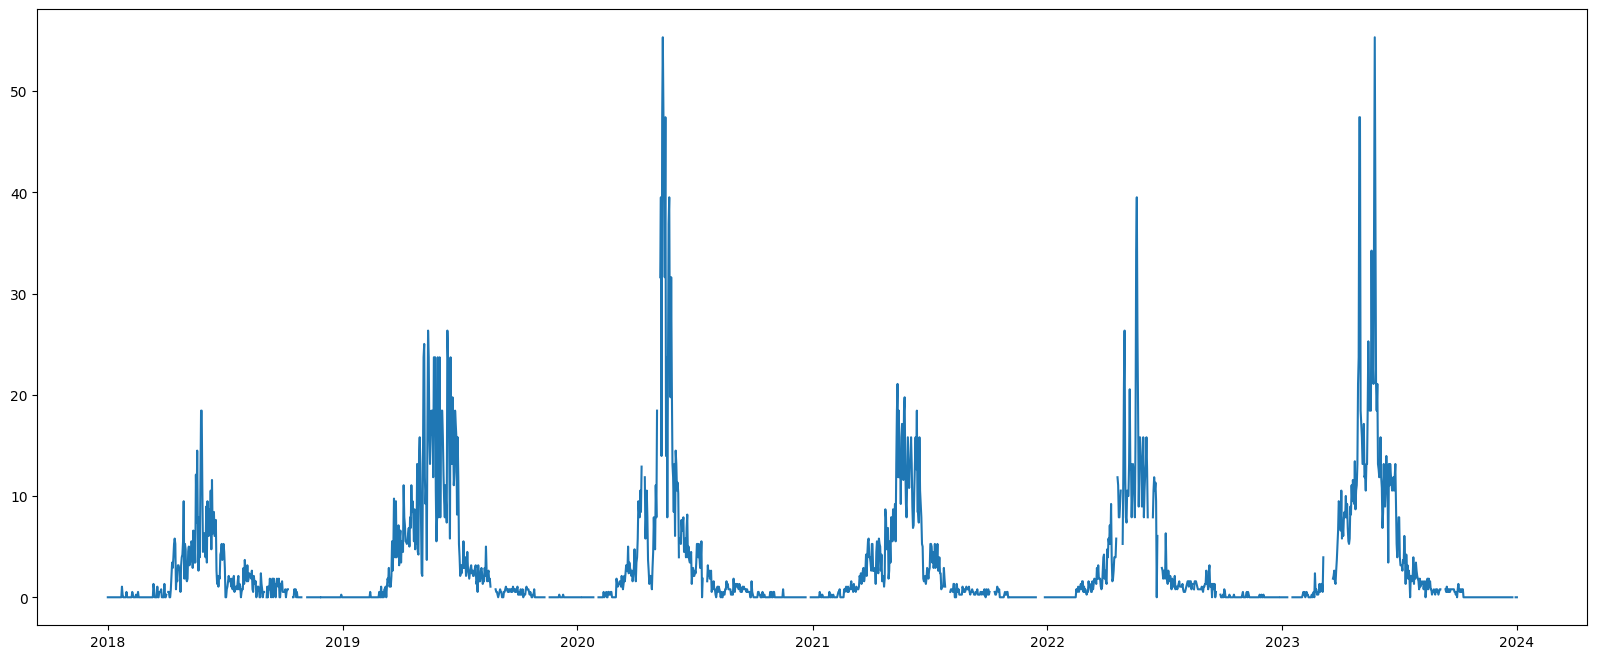

In [205]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df.date, df.concentration)

plt.show()

In [206]:
# Assuming you have the preprocessed DataFrame 'df'
df = df.loc[df.concentration.notnull()]
df["day"] = df.date.dt.day
df["month"] = df.date.dt.month
df["year"] = df.date.dt.year
df["day_of_week"] = df.date.dt.day_of_week
df["timestamp"] = df.date.apply(lambda x: x.timestamp())
df["month_sin"] = np.sin(2 * np.pi * df.date.dt.month / 12)
df["month_cos"] = np.cos(2 * np.pi * df.date.dt.month / 12)
df["years_since_start"] = df.date.dt.year - df.date.dt.year.min()
df["season"] = (df.date.dt.month % 12 + 3) // 3

# Normalize the 'concentration' column
df.concentration = (df.concentration - df.concentration.min()) / (
    df.concentration.max() - df.concentration.min()
)

# Save the processed DataFrame to a CSV file
df.to_csv("input/pollen.csv", index=False)

In [207]:
class PollenDataset(Dataset):
    feature_columns = [
        # "month_sin",
        # "month_cos",
        # "day",
        "day_of_week",
        "month",
        "year",
        # "years_since_start",
        # "timestamp",
        "season",
    ]

    def __init__(self, csv_filename) -> None:
        self.data = pd.read_csv(csv_filename)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = self.data.loc[
            [idx],
            self.feature_columns,
        ]

        # print(features)
        label = self.data.iloc[idx]["concentration"]
        label = torch.tensor(label).float().unsqueeze(0)
        return torch.tensor(features.values).float().squeeze(), label


class PollenForecast(nn.Module):
    def __init__(
        self,
        input_size=len(PollenDataset.feature_columns),
        hidden_size=64,
        output_size=1,
    ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


pollen_dataset = PollenDataset("input/pollen.csv")

# Split the dataset into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    pollen_dataset, pollen_dataset.data["concentration"], test_size=0.2, random_state=42
)

# Create the train and test dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

X, y = next(iter(train_loader))
print(X.shape, y.shape)


# input_size = 8  # Number of input features
# hidden_size = 64
# output_size = 1  # Number of output features (pollen concentration)
learning_rate = 0.001
epochs = 100

model = PollenForecast()


loss_fn = nn.MSELoss()


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

torch.Size([32, 4]) torch.Size([32, 1])


In [208]:
model = model.to("mps")

model = model.to("mps")
for epoch_idx in range(epochs):
    model.train()
    for X, y in train_loader:
        X = X.to("mps")
        y = y.to("mps")
        optimizer.zero_grad()
        pred = model(X)

        # print(X.shape, y.shape, pred.shape)
        # sleep(50)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_loss = 0
        for X, y in test_loader:
            X = X.to("mps")
            y = y.to("mps")

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
        if epoch_idx == epochs - 1:
            print(X[:2], y[:2], pred[:2])
        test_loss /= len(test_loader)

    print(
        f"Epoch [{epoch_idx+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}"
    )

IndexError: too many indices for tensor of dimension 2